## Задание. Создать нейронную сеть со следующей структурой


Network( <br/>
    (hidden): Linear(in_features=784, out_features=256, bias=True) <br/>
    (output): Linear(in_features=256, out_features=10, bias=True) <br/>
    (sigmoid): Sigmoid() <br/>
    (softmax): Softmax(dim=1) <br/>
)


Подключить необходимые библиотеки: torch, numpy и matplotlib.pyplot:

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

Создать класс и описать в нём необходимую нам структуру:

In [2]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(in_features=784, out_features=256, bias=True)
        self.output = nn.Linear(in_features=256, out_features=10, bias=True)
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)



    def forward(self, x):
        x = self.hidden(x)
        x = self.sigmoid(x)
        x = self.output(x)
        x = self.softmax(x)

        return x


Создадим экземпляр класса и выведем его на печать, чтобы проверить, что наша архитектура совпадает с заданной:

In [3]:
model = Net()
print(model)

Net(
  (hidden): Linear(in_features=784, out_features=256, bias=True)
  (output): Linear(in_features=256, out_features=10, bias=True)
  (sigmoid): Sigmoid()
  (softmax): Softmax(dim=1)
)


Будем использовать набор данных MNIST. Применим трансформации перевода в тензор и нормализации с параметрами (0.5):

In [4]:
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose( [
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])

# Download and load the training data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 78894137.06it/s]


Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 7072791.14it/s]


Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 39043274.56it/s]

Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 15119467.28it/s]


Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw



Зададим функцию view_classify для более удобного вывода результатов на экран:

In [5]:
def view_classify(img, ps, version="MNIST"):
    '''
    Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

Будем итерироваться по тренировочному множеству и выведем результат работы нейронной сети на экран:

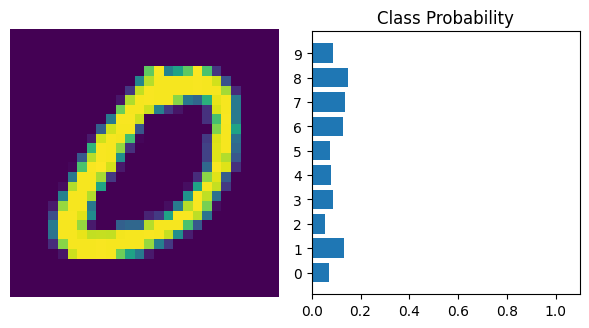

In [6]:
# Grab some data
for batch_idx, (test_data, test_targets) in enumerate(trainloader):
  images = test_data
  break

# Resize images into a 1D vector, new shape is (batch size, color channels, image pixels)
images.resize_(64, 1, 784)
# or images.resize_(images.shape[0], 1, 784) to automatically get batch size

# Forward pass through the network
model = Net()
img_idx = 0
ps = model.forward(images[img_idx,:])

img = images[img_idx]
view_classify(img.view(1, 28, 28), ps)

Вопрос: почему получилось такое распределение вероятностей предсказаний классов?

Ответ: веса в этой нейронной сети задавались случайным образом, то есть сеть никак не обучалась.

## Обучение нейронной сети

Суть обучения нейронной сети заключается в подборе (посредством постепенного изменения) весов и bias-векторов (параметров сети) таким образом, чтобы разница между выходом нейронной сети и целевым значением была минимальна.

Для этого строится **функция потерь (Loss function)** - функция, которая оценивает <<расстояние>> между значением, которое получилось на выходе нейронной сети (Prediction), и заранее заданным значением (Labels).

Чтобы минимизировать функцию потерь, используется метод обратного распространения ошибки (Backpropagation), суть которого заключается в нахождении минимума функции потерь через вычисление её градиента, который в свою очередь зависит только от входных данных (поэтому обратное распространение).

Метод обратного распространения ошибки включает в себя следующие шаги:
* Forward Pass (FP) — прямое распространение сигнала от входа к выходам (без которого не получить вычисленные значения в графе);
* Backward Pass (BP) — расчёт величины градиента от выхода ко входам;
* обновление весов в зависимости от величины градиента (скорость обучения или learning rate).

<img src="assets/forward_backward_pass.png" width='800'>

Существует несколько реализаций метода обратного распространения ошибки:
- стохастического градиентного спуска (Stochastic Gradient Descent, SGD);
- пакетного градиентного спуска (Mini-Bath Gradient Descent, MBGD).

Итого, один цикл обучения включает:
- загрузку данных (Features);
- один проход данных сквозь нейронную сеть (Neural Network);
- получение предсказаний нейронной сети (Prediction);
- выгрузка значений, которые соответствуют данным (Labels);
- построение функции потерь (Loss) от двух параметров Prediction и Loss;
- применение метода обратного распространения ошибки (Backpropagation).

<img src="assets/Training_cycle.png" width= "800">

Например, внутри одной эпохи обучения двухслойной неронной сети необходимо выполнять следующие действия:
- предобработать данные;
- умножить их на веса;
- применить функцию активации;
- снова умножить на веса;
- вычислить значение функции потерь;
- вычислить градиент функции потерь по весам;
- обновить веса;
- оценить точность.

Нейронная сеть в процессе **обучения** последовательно обрабатывает все объекты из обучающей выборки.
Предъявление нейронной сети всех объектов обучающей выборки по одному разу называется **эпохой обучения**.

Обучающую выборку разделяют на две части: непосредственно использующуюся для обучения (train data) и тестовую (test data) или валидационную (validation data). На тестовых данных каждую эпоху происходит оценка качества обучения. Стратегия разделения на train и test/validation подвыборки может быть произвольной, но при разделении следует заботиться о том, чтобы эти подвыборки были "похожи".

Обучение модели — итеративный процесс. На каждой итерции модель получает входные данные, дает предсказание на выходе, вычисляет значение функции потерь (loss), вычисляет производные функции потерь по параметрам и подстраивает параметры, используя градиентный спуск. Для более детального рассмотрения этого процесса рекомендуем посмотреть [видео об обратном распространении ошибки от 3Blue1Brown](https://www.youtube.com/watch?v=tIeHLnjs5U8).

[Плейлист с видео о нейронных сетях от 3Blue1Brown с озвучкой на русском](https://www.youtube.com/playlist?list=PLfdZ2TeaMzfzlpZ60rbaYU_epH5XPNbWU).

## Гиперпараметры

Гиперпараметры — это задаваемые разработчиком параметры, которые позволяют управлять процессом обучения. Различные значения гиперпараметров могут влиять на обучение модели и скорость сходимости ([здесь](https://pytorch.org/tutorials/beginner/hyperparameter_tuning_tutorial.html) можно почитать подробнее про подбор гиперпараметров).

Определим следующие гиперпараметры процедуры обучения:
* **количество эпох** (`num_epochs`) — количество итераций обучения по всему набору данных;
* **размер батча** (`batch_size`) — количество образцов, передаваемых в сеть для обновления параметров;
* **скорость обучения** (`learning_rate`) — коэффициент, определяющий, насколько сильно нужно обновлять параметры модели на каждом батче. Малые значения приводят к долгому обучению, в то время как большие значения могут приводить к непредсказуемому поведению во время обучения.

In [7]:
num_epochs = 10
batch_size = 64
learning_rate = 1e-3

## Функция потерь (Loss function)

При получении некоторых обучающих данных наша необученная сеть, скорее всего, не даст правильного ответа. Функция потерь измеряет степень различия между значениями на выходе сети и целевыми значениями. Именно функцию потерь мы и хотим минимизировать во время обучения. Для вычисления функции потерь нужно получить предсказание модели, передав ей на вход пример из данных, и сравнить его с истинным значением целевой переменной.

Наиболее часто применяемыми функциями потерь являются [`nn.MSELoss`](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html#torch.nn.MSELoss) (Mean Square Error) для задач регрессии и [`nn.CrossEntropyLoss`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss) для задач класиификации.


Мы будем передавать выходы модели (логиты) в `nn.CrossEntropyLoss`, которая будет их нормализовывать и вычислять ошибку предсказания.

In [8]:
criterion = nn.CrossEntropyLoss()

## Оптимизатор (Optimizer)

Оптимизация — это процесс подстройки параметров модели для уменьшения ошибки на каждом шаге обучения. От **алгоритма оптимизации** зависит то, как этот процесс будет выполняться. Здесь мы будем использовать стохастический градиентный спуск (Stochastic Gradient Descent, SGD). Однако в PyTorch реализовано еще [множество других алгоритмов оптимизации](https://pytorch.org/docs/stable/optim.html#algorithms), таких как Adam и RMSProp, и они могут работать лучше или хуже для разных видов моделей и данных.

Вся логика оптимизации заключена в объекте `optimizer`. Мы инициализируем оптимизатор, передавая ему параметры модели, которые требуется обучать (`model.parameters()`), а также гиперпараметр скорости обучения (`learning_rate`).

In [9]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

## Цикл обучения

Внутри цикла обучения, оптимизация производится за три шага:
1. Вызов `optimizer.zero_grad()`, чтобы сбросить градиенты параметров модели. По умолчанию градиенты суммируются, и во избежание повторного вычисления их необходимо явно обнулять на каждой итерации;
2. Обратное распространение ошибки предсказания с помощью вызова `loss.backward()`. PyTorch вычислит градиенты функции потерь относительно каждого обучаемого параметра;
3. Когда у нас есть градиенты, мы вызываем `optimizer.step()`, чтобы подстроить обучаемые параметры с учетом градиентов, посчитанных при обратном распространении, согласно алгоритму оптимизации.

Итого, в цикле обучения в следующем порядке должны идти строчки:  <br>
optimizer.zero_grad() <br>
loss.backward()  <br>
optimizer.step()  <br>

Наиболее просто полный процесс обучения нейронной сети может быть представлен следующим кодом:

In [10]:
from torch import optim

model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1))


num_epochs = 5
learning_rate = 0.003

criterion = nn.NLLLoss()

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

for e in range(num_epochs):
    running_loss = 0
    for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)

        # Training pass
        output = model(images)
        loss = criterion(output, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    else:
        print(f"Training loss: {running_loss/len(trainloader)}")

Training loss: 1.8605882799955828
Training loss: 0.7988455540526396
Training loss: 0.5089772067535152
Training loss: 0.42398820633191797
Training loss: 0.38239946965374416


Посмотрим на вероятности предсказанных классов после обучения нейронной сети:

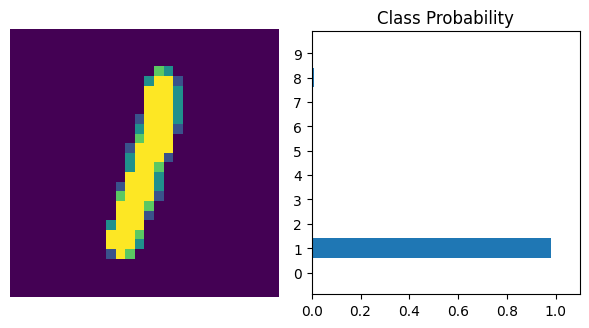

In [11]:
%matplotlib inline

images, labels = next(iter(trainloader))

img = images[0].view(1, 784)
# Turn off gradients to speed up this part
with torch.no_grad():
    logps = model(img)

# Output of the network are log-probabilities, need to take exponential for probabilities
ps = torch.exp(logps)
view_classify(img.view(1, 28, 28), ps)

Видим, что нейронная сеть уже научилась распознавать цифры с достаточно большой вероятностью.

# Пример нейронной сети для решения задачи классификации на наборе данных MNIST

Задание: собрать нейронную сеть из ноутбука L05_Neural_networks.ipynb

In [12]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers_stack = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.layers_stack(x)
        return logits


model = NeuralNetwork()
model

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layers_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
)

## Обработка результатов:

Поэтапно пропустим тестовые изображения через модель и посмотрим на размерности:

In [13]:
testset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)
test_dataloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

In [14]:
# get batch
imgs, labels = next(iter(test_dataloader))
print("imgs shape: ", imgs.shape)

imgs shape:  torch.Size([64, 1, 28, 28])


In [16]:
# get output
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


Посмотрим на результаты обработки нейронной сети для выбранного батча:

In [18]:
# First sample in prediction batch
pred = model(imgs.to(device))
pred[0]

tensor([-0.0793,  0.0513, -0.0911,  0.2170, -0.1051, -0.0754,  0.1358, -0.0731,
         0.0429, -0.0593], grad_fn=<SelectBackward0>)

Чтобы посчитать вероятность, применим функццию softmax:

In [19]:
# Calculate probabilities
nn.Softmax(dim=0)(pred[0].detach())

tensor([0.0922, 0.1050, 0.0911, 0.1240, 0.0898, 0.0926, 0.1143, 0.0928, 0.1042,
        0.0941])

Изменим размерности данных для вывода картинок на экран:

In [20]:
# remove axis
imgs = torch.reshape(imgs, (64, 28, 28))
print("imgs shape(after reshape): ", imgs.shape)

imgs shape(after reshape):  torch.Size([64, 28, 28])


In [21]:
# take 10 first images
imgs = imgs[:10]
print("imgs shape: ", imgs.shape)

imgs shape:  torch.Size([10, 28, 28])


Посмотрим на предсказанные вероятности и выведем позицию максимального значения:

In [22]:
import numpy as np

pred = pred[:10].detach()
print("Prediction(1 sample):\n", pred[0])
digits = np.argmax(pred.cpu().numpy(), axis=1)
print("Predicted class: ", digits[0])

Prediction(1 sample):
 tensor([-0.0793,  0.0513, -0.0911,  0.2170, -0.1051, -0.0754,  0.1358, -0.0731,
         0.0429, -0.0593])
Predicted class:  3


Визуализируем изображения, подпишем предсказанное и истинное значение:

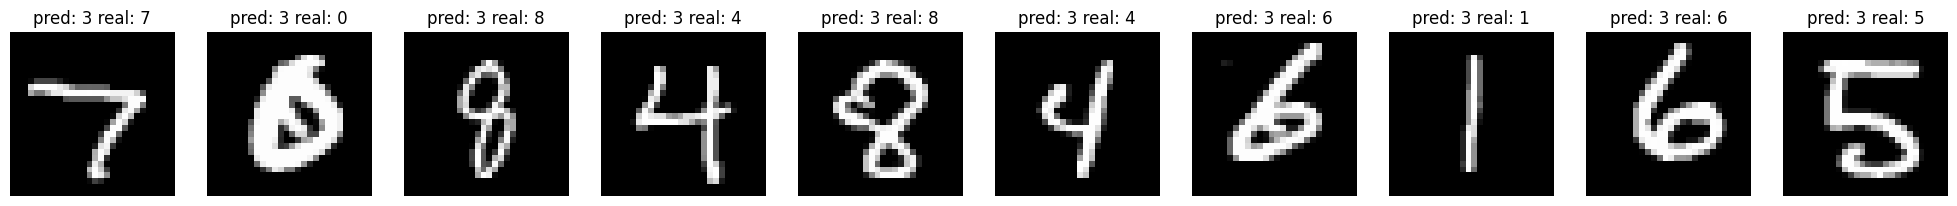

In [23]:
plt.figure(figsize=(25.0, 25.0))
for i in range(10):
    img = imgs[i]

    plt.subplot(1, 10, i + 1)
    plt.title(
        "pred: " + str(digits[i]) + " real: " + str(labels[i].numpy())
    )  # predicted and real values
    plt.axis("off")
    plt.imshow(img.numpy(), cmap="gray")

## Сохранение и загрузка весов модели

Обычно обучение модели является достаточно затратным процессом с точки зрения вычислительных ресурсов. Поэтому, однажды обучив сеть, разумно будет сохранить ее для последующего использования. Рассмотрим варианты, как это можно сделать в PyTorch.

Модели PyTorch хранят обучаемые параметры во внутреннем словаре состояния, который называется `state_dict`. Их можно сохранить с помощью метода `torch.save`.


In [24]:
torch.save(model.state_dict(), "model_weights.pth")

Для того, чтобы загрузить веса модели, сперва необходимо создать экземпляр такой модели, а затем загрузить параметры с помощью метода `load_state_dict()`.

In [25]:
model = NeuralNetwork()
model.load_state_dict(torch.load("model_weights.pth"))
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layers_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [26]:
imgs, labels = next(iter(test_dataloader))
pred = model(torch.reshape(imgs, (64, 28, 28)).to(device))

In [27]:
pred = pred.detach()
print("Prediction(1 sample):\n", pred)
digits = np.argmax(pred.cpu().numpy(), axis=1)
print(digits)

Prediction(1 sample):
 tensor([[-6.2385e-02, -7.1276e-02, -7.3745e-02,  2.3560e-01, -8.2673e-02,
         -8.9156e-03,  5.1591e-02, -7.1590e-02, -4.0679e-02,  4.3940e-02],
        [-9.8546e-02,  2.3212e-02, -1.0355e-01,  1.2057e-01, -4.9833e-02,
         -6.2324e-02,  9.5826e-02, -4.0621e-02, -4.0019e-02, -3.4661e-02],
        [-1.1217e-01, -1.1919e-02, -1.0002e-01,  1.1553e-01, -4.3048e-02,
         -1.8298e-01,  1.7638e-03, -7.8524e-02, -4.8294e-02,  2.7658e-02],
        [-8.8765e-02,  2.3205e-02, -1.4378e-01,  1.6056e-01, -7.1143e-02,
         -1.0180e-01,  6.9788e-02, -5.9556e-02, -1.3945e-02, -2.6192e-02],
        [-1.1851e-03,  2.4201e-03, -1.5858e-01,  3.1898e-01,  3.0140e-02,
         -6.1950e-02,  8.8167e-02, -2.2494e-02, -4.8429e-03, -2.0760e-02],
        [-9.0171e-02,  4.5572e-02, -1.5796e-01,  1.8933e-01, -9.3532e-02,
         -9.0317e-02,  3.0980e-02, -5.8259e-02, -3.8510e-02, -2.2956e-02],
        [-5.5803e-02,  1.0648e-01, -7.8162e-02,  2.1271e-01, -3.9608e-03,
         